In [1]:
# import libraries
%matplotlib inline
import numpy as np
import csv
import matplotlib.pyplot as plt
import pandas as pd
import glob
import ulmo
import os

In [ ]:
# automatically download data 
# stationIDs = {'Baltimore': 'USW00093784',}
# import ulmo
# st = ulmo.ncdc.ghcn_daily.get_stations(country='US', as_dataframe=True)
#st[st.name.str.contains('BIRMINGHAM')]

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:24: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


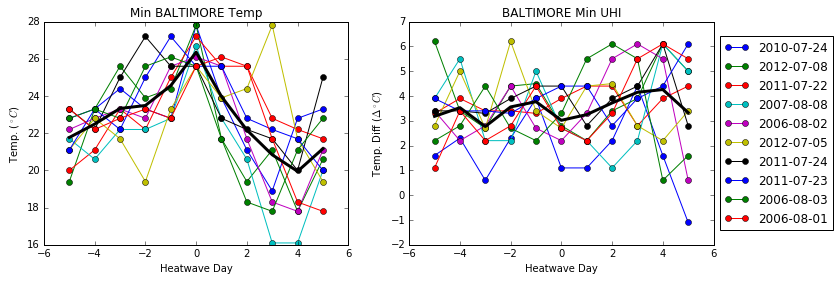

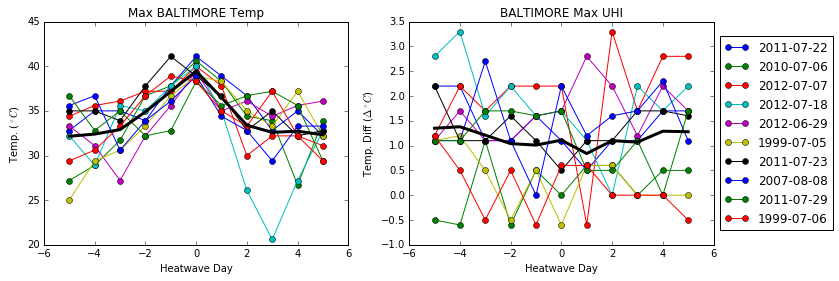

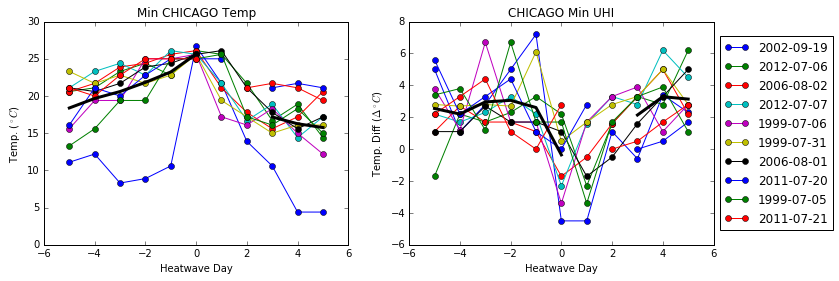

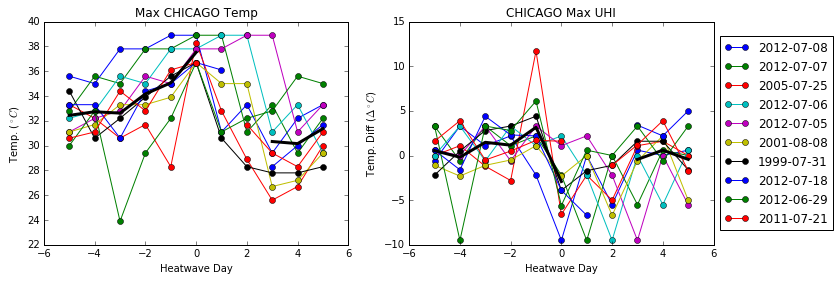

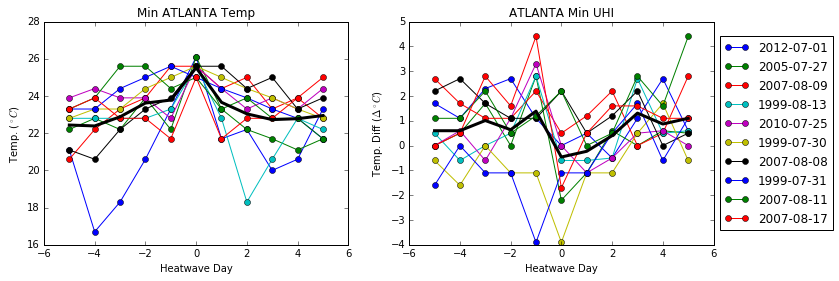

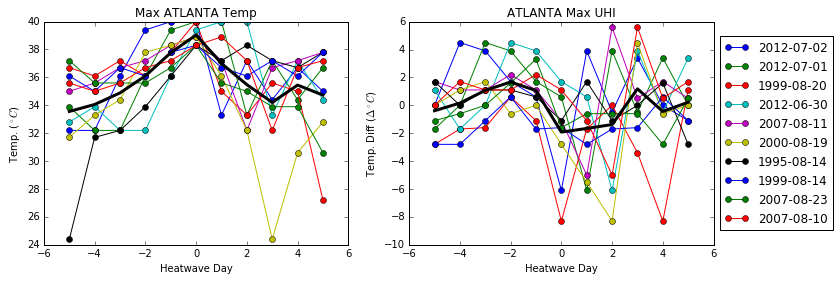

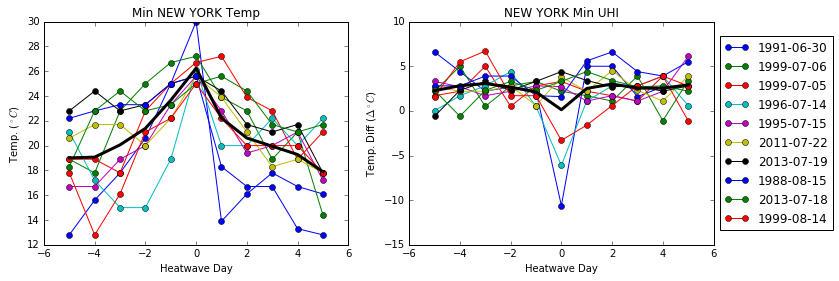

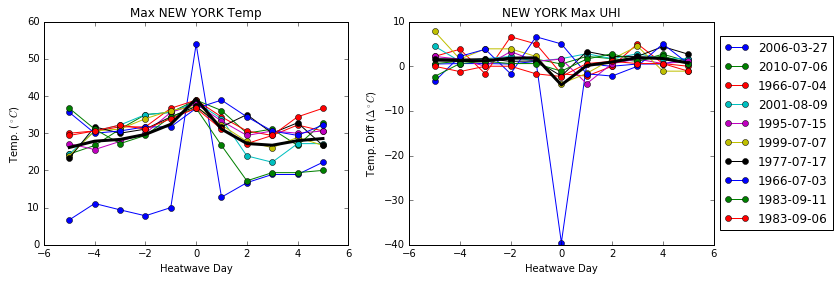

In [389]:
# List all the stations, their type (urban/rural), and their station ID to download from the NCDC ftp site
stationlist = np.array([('BALTIMORE', 'urban', 'USW00093784'),
        ('BALTIMORE', 'rural', 'USW00093721'),
#        ('SAN FRANCISCO', 'urban', 'USW00023272') , 
#        ('SAN FRANCISCO', 'rural', 'USW00023234'), # airport
#        ('SEATTLE', 'rural', 'USW00024233'), #seatac USW0002428
#        ('SEATTLE', 'urban', 'USW00094290'), #sandpoint  
#        ('BIRMINGHAM', 'urban', 'USW00013876'), #airport
#        ('BIRMINGHAM', 'rural', 'USC00011225'),# pumphouse  'USW00003883'), #
        ('CHICAGO', 'urban', 'USW00014819'), #midway
        ('CHICAGO', 'rural', 'USC00112736'), 
        ('ATLANTA', 'urban', 'USW00013874'), # airport
        ('ATLANTA', 'rural', 'USC00094700'), # jonesboro, GA 
        ('NEW YORK', 'urban', 'USW00014732'), # laguardia, 
        ('NEW YORK', 'rural', 'USW00094745'), #westchester county airport
                       ])
df = pd.DataFrame(stationlist, columns = ['city', 'type', 'number'])
df = df.set_index(df.number)

for city in df.city.unique(): 
    # Downloadd from NCDC the station data, using the station ID listed in station list
    urbandata = ulmo.ncdc.ghcn_daily.get_data(str(df[df.city==city][df.type=='urban'].index[0]),
                                         as_dataframe=True)
    ruraldata = ulmo.ncdc.ghcn_daily.get_data(str(df[df.city==city][df.type=='rural'].index[0]),
                                         as_dataframe=True)
    
    # Find the date at which they both start
    startdate = max(min(ruraldata['TMIN'].index), min(urbandata['TMIN'].index))

    # Calculate minimum daily thresholds starting from 1965
    tmin = pd.to_numeric(ruraldata['TMIN']['1965-01-01':].value/10.) 
    filename = './data/mindailytempthresholds'+city+ '.npy'
    if os.path.isfile(filename): 
        minthresh = np.load(filename)
    else: 
        summary = tmin.groupby(tmin.index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
        ninetieth = summary.values[5::10]
        ninetyfifth = summary.values[6::10]
        ninetyeigth = summary.values[7::10]
        ninetyninth = summary.values[8::10]
        minthresh = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
        np.save(('./data/mindailytempthresholds'+city), minthresh)

    # Calculate maximum  daily thresholds
    tmax = pd.to_numeric(ruraldata['TMAX']['1965-01-01':].value/10.) 
    filename = './data/maxdailytempthresholds'+city+ '.npy'
    if os.path.isfile(filename): 
        maxthresh = np.load(filename)
    else: 
        summary = tmax.groupby(tmax.index.dayofyear).describe(percentiles =  [.90, .95, .98, .99])
        ninetieth = summary.values[5::10]
        ninetyfifth = summary.values[6::10]
        ninetyeigth = summary.values[7::10]
        ninetyninth = summary.values[8::10]
        maxthresh = np.array([ ninetieth, ninetyfifth,ninetyeigth, ninetyninth])
        np.save(('./data/maxdailytempthresholds'+city), maxthresh)
    
    numhw = 10 # number of heatwaves
    
    # min hw
    tmin = tmin[startdate:]
    hottestmin = tmin.iloc[(-tmin.values).argsort()[:numhw]] #Get the hottest days based off tmin 
    ind = np.where(hottestmin.values- minthresh[1,hottestmin.index.dayofyear] >0)
    minheatwaves = hottestmin.iloc[ind]
    # check that these are heatwaves
    ind2 = np.where(minheatwaves- minthresh[1,hottest.index.dayofyear+1] >0)[0]
    minheatwaves = minheatwaves[ind2]
    # check that these last 48 hours 

    # check that these aren't all the same event 


    # max hw
    tmax = tmax[startdate:]
    hottestmax = tmax.iloc[(-tmax.values).argsort()[:numhw]]# Get the hottest days based off tmax
    ind = np.where(hottestmax.values- maxthresh[1,hottestmax.index.dayofyear] >0)
    maxheatwaves = hottestmax.iloc[ind]
    # check that these last 48 hours
    ind2 = np.where(maxheatwaves- maxthresh[1,hottestmax.index.dayofyear+1] >0)[0]
    maxheatwaves = maxheatwaves[ind2]
    # check that these aren't all the same event

    # check that they aren't the same event...
    if minheatwaves.shape[0]==0: 
        print 'No min heatwaves detected for %s' %city
    if maxheatwaves.shape[0]==0: 
        print 'No Max heatwaves detected for %s' %city

    #calculate UHI
    UHImin = pd.to_numeric(urbandata['TMIN'].value/10.) - tmin
    UHImax = pd.to_numeric(urbandata['TMAX'].value/10.) - tmax
    compositeTemp = np.zeros([minheatwaves.shape[0], 11])
    compositeUHI = np.zeros([minheatwaves.shape[0], 11])


    j = 0
    for UHI, temp, heatwaves in zip([UHImin,UHImax], [tmin,tmax], [minheatwaves, maxheatwaves]): 
            minmax = dict[j]
            i = 0
            for dates in heatwaves.index[:]: 
                compositeUHI[i,:] = UHI[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                compositeTemp[i,:]= temp[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
                i = i+1

            plt.figure(figsize=[12,4])
            plt.subplot(1,2,1)
            tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
            plt.plot(np.arange(-5,6,1),compositeTemp.mean(axis=0), linewidth = 3, color = 'black')
            #plt.plot(temp.index, minthresh[1][i-5:i+5], color = 'grey')
            plt.title('%s %s Temp'%(minmax, city))
            plt.ylabel('Temp. ($^\circ C$)')
            plt.xlabel('Heatwave Day')

            plt.subplot(1,2,2)    
            uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
            plt.plot(np.arange(-5,6,1),compositeUHI.mean(axis=0), linewidth = 3,color = 'black')
            plt.title('%s %s UHI'%(city, minmax))
            plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
            plt.xlabel('Heatwave Day')
            plt.legend(heatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))

            j = j+1
#     dict = ['Min', 'Max']
#     j = 0        
#     #for temp in [tmin, tmax] : 
#         #hottestmin = temp.iloc[(-temp.values).argsort()[:numhw]]
#     # Minimum heatwaves
#     hottestmin = tmin.iloc[(-tmin.values).argsort()[:numhw]] #Get the hottest days based off tmin 
#     ind = np.where(hottestmin.values- minthresh[1,hottestmin.index.dayofyear] >0)
#     minheatwaves = hottestmin.iloc[ind]
#     # check that these last 48 hours
#     ind2 = np.where(minheatwaves- minthresh[1,hottest.index.dayofyear+1] >0)[0]
#     minheatwaves = minheatwaves[ind2]
    
#     # Maximum heatwaves
#     hottestmax = tmax.iloc[(-tmax.values).argsort()[:numhw]] # Get the hottest days based off tmax
#     ind = np.where(hottestmax.values- maxthresh[1,hottestmax.index.dayofyear] >0)
#     maxheatwaves = hottestmax.iloc[ind]
#     # check that these last 48 hours
#     ind2 = np.where(maxheatwaves- maxthresh[1,hottestmax.index.dayofyear+1] >0)[0]
#     maxheatwaves = maxheatwaves[ind2]
    
#     # check that they aren't the same event...
#     if minheatwaves.shape[0]==0: 
#         print 'No min heatwaves detected for %s' %city
#     if maxheatwaves.shape[0]==0: 
#         print 'No Max heatwaves detected for %s' %city
        
#     #calculate UHI
#     UHImin = pd.to_numeric(urbandata['TMIN'].value/10.) - tmin
#     UHImax = pd.to_numeric(urbandata['TMAX'].value/10.) - tmax
#     compositeTemp = np.zeros([minheatwaves.shape[0], 11])
#     compositeUHI = np.zeros([minheatwaves.shape[0], 11])

    
#     for UHI in [UHImin, UHImax]: 
#         minmax = dict[j]
#         i = 0
#         for dates in heatwaves.index[:]: 
#             compositeUHI[i,:] = UHI[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
#             compositeTemp[i,:]= tmin[dates.to_timestamp()-pd.DateOffset(days=5):dates.to_timestamp()+pd.DateOffset(days=5)].values
#             i = i+1

#         plt.figure(figsize=[12,4])
#         plt.subplot(1,2,1)
#         tHandle = plt.plot(np.arange(-5,6,1),compositeTemp.T, '-o')
#         plt.plot(np.arange(-5,6,1),compositeTemp.mean(axis=0), linewidth = 3, color = 'black')
#         #plt.plot(temp.index, minthresh[1][i-5:i+5], color = 'grey')
#         plt.title('%s %s Temp'%(minmax, city))
#         plt.ylabel('Temp. ($^\circ C$)')
#         plt.xlabel('Heatwave Day')

#         plt.subplot(1,2,2)    
#         uhiHandle = plt.plot(np.arange(-5,6,1),compositeUHI.T, '-o')
#         plt.plot(np.arange(-5,6,1),compositeUHI.mean(axis=0), linewidth = 3,color = 'black')
#         plt.title('%s %s UHI'%(city, minmax))
#         plt.ylabel('Temp. Diff ($\Delta ^\circ C$)')
#         plt.xlabel('Heatwave Day')
#         plt.legend(heatwaves.index, loc = 'center left', bbox_to_anchor=(1.0, 0.5))
        
#         j = j+1

In [377]:
giss[giss.name.str.contains('SAN FRANCISCO')]

,icc country code,WMO ID,3 digit modifier,name,lat,lon,elevation,TELe,P,Pop,Tp,V,Lo,Co,Airport,ds,Vege,bi,BI
3162,407,78460,3,SAN FRANCISCO DE MACORIS D,19.30,70.30,110,210,U,65,HI,xx,o,-9,x,-9,WARM CROPS,B,8
4958,425,72494,0,SAN FRANCISCO,37.62,22.38,5,102,U,6253,FL,xx,O,15,A,1,COASTAL EDGES,C,66
5188,425,74506,2,SAN FRANCISCO/MISSION DOLORES,37.77,22.43,22,70,U,6253,HI,xx,O,1,x,-9,COASTAL EDGES,C,106
6065,509,98437,0,SAN FRANCISCO,13.37,22.52,45,125,R,-9,HI,xx,O,1,x,-9,WATER,A,0


In [378]:
giss[giss.name.str.contains('NEW YORK')]

,icc country code,WMO ID,3 digit modifier,name,lat,lon,elevation,TELe,P,Pop,Tp,V,Lo,Co,Airport,ds,Vege,bi,BI
4962,425,72503,2,NEW YORK/FORT TOTTEN,40.78,73.77,7,22,U,9342,FL,xx,O,1,x,-9,WARM CROPS,C,92
5173,425,74486,1,NEW YORK/FLOYD BENNETT FIELD,40.58,73.88,10,3,U,9342,FL,xx,O,3,A,1,WARM CROPS,C,30


In [379]:
giss[giss.name.str.contains('ATLANTA')]

,icc country code,WMO ID,3 digit modifier,name,lat,lon,elevation,TELe,P,Pop,Tp,V,Lo,Co,Airport,ds,Vege,bi,BI
4665,425,72219,0,"ATLANTA/MUN.,",33.65,84.42,315,285,U,2960,FL,xx,o,-9,A,1,WARM FOR./FIELD,C,112


In [383]:
giss[giss.name.str.contains('SEATTLE')]

,icc country code,WMO ID,3 digit modifier,name,lat,lon,elevation,TELe,P,Pop,Tp,V,Lo,Co,Airport,ds,Vege,bi,BI
4501,425,457,458,SEATTLE URBAN SITE,47.65,22.30,6,60,U,2970,HI,xx,O,1,x,-9,COOL FIELD/WOODS,C,89
5138,425,72793,0,SEATTLE WASHINGTON,47.60,22.33,6,56,U,2970,HI,xx,O,1,x,-9,COOL FIELD/WOODS,C,107
5141,425,72793,6,SEATTLE/PORTAGE BAY,47.65,22.30,5,60,U,2970,HI,xx,O,1,x,-9,COOL FIELD/WOODS,C,89
5142,425,72793,8,SEATTLE/NAS,47.68,22.27,12,64,U,2970,HI,xx,O,1,x,-9,COOL FIELD/WOODS,C,62


In [388]:
ghcn[ghcn.name.str.contains('ATLANTA')]

,GHCN ID,lat,lon,elevation,state,name,gsn flag,HCN/CRN FLAG,WMO ID
53764,US1GADK000,33.859,-84.325,272.0,G,NORTH ATLANTA 0.5 ESE,NaN,NaN,NaN
53768,US1GADK001,33.852,-84.286,269.0,G,NORTH ATLANTA 2.8 ESE,NaN,NaN,NaN
53776,US1GADK002,33.752,-84.312,307.0,G,ATLANTA 4.4 E,NaN,NaN,NaN
53779,US1GADK002,33.765,-84.330,302.0,G,ATLANTA 3.5 ENE,NaN,NaN,NaN
53783,US1GADK003,33.796,-84.334,282.0,G,ATLANTA 5.6 ENE,NaN,NaN,NaN
53784,US1GADK003,33.812,-84.337,283.0,G,ATLANTA 6.0 NE,NaN,NaN,NaN
53847,US1GAFT000,33.841,-84.358,267.0,G,NORTH ATLANTA 2.0 SW,NaN,NaN,NaN
53849,US1GAFT000,33.816,-84.417,264.0,G,ATLANTA 3.7 N,NaN,NaN,NaN
53854,US1GAFT001,33.797,-84.413,274.0,G,ATLANTA 2.4 NNE,NaN,NaN,NaN
53859,US1GAFT002,33.788,-84.396,278.0,G,ATLANTA 2.3 NE,NaN,NaN,NaN


In [387]:
ghcn[ghcn.name.str.contains('SEATTLE')]

,GHCN ID,lat,lon,elevation,state,name,gsn flag,HCN/CRN FLAG,WMO ID
72237,US1WAKG000,47.686,-122.393,91.0,W,SEATTLE 4.9 NNW,NaN,NaN,NaN
72246,US1WAKG002,47.651,-122.330,8.0,W,SEATTLE 2.2 NNE,NaN,NaN,NaN
72255,US1WAKG003,47.652,-122.409,93.0,W,SEATTLE 3.5 NW,NaN,NaN,NaN
72257,US1WAKG004,47.640,-122.390,74.0,W,SEATTLE 2.3 NW,NaN,NaN,NaN
72265,US1WAKG005,47.543,-122.381,113.0,W,SEATTLE 5.6 SSW,NaN,NaN,NaN
72269,US1WAKG006,47.645,-122.323,43.0,W,SEATTLE 2.0 NE,NaN,NaN,NaN
72272,US1WAKG007,47.577,-122.412,6.0,W,SEATTLE 4.2 SW,NaN,NaN,NaN
72277,US1WAKG007,47.640,-122.408,93.0,W,SEATTLE 3.0 WNW,NaN,NaN,NaN
72279,US1WAKG008,47.667,-122.361,47.0,W,SEATTLE 3.2 N,NaN,NaN,NaN
72280,US1WAKG008,47.571,-122.283,-999.0,W,SEATTLE 4.5 SE,NaN,NaN,NaN


In [382]:
ghcn[ghcn.name.str.contains('NEW YORK')]

,GHCN ID,lat,lon,elevation,state,name,gsn flag,HCN/CRN FLAG,WMO ID
82022,USC0021590,46.523,-95.384,428.0,M,NEW YORK MILLS,NaN,NaN,NaN
86022,USC0030579,40.600,-73.966,6.0,N,NEW YORK BENSONHURST,NaN,NaN,NaN
86023,USC0030579,40.866,-73.883,27.0,N,NEW YORK BOTANICAL GRD,NaN,NaN,NaN
86024,USC0030580,40.733,-73.933,3.0,N,NEW YORK LAUREL HILL,NaN,NaN,NaN
86025,USC0030580,40.850,-73.916,54.0,N,NEW YORK UNIV ST,NaN,NaN,NaN
86026,USC0030581,40.700,-74.016,3.0,N,NEW YORK WB CITY,NaN,NaN,NaN
96954,USR0000NGA,42.100,-77.100,335.0,N,GANG MILLS NEW YORK,NaN,NaN,NaN
97004,USR0000NSA,43.007,-73.651,114.0,N,SARA NEW YORK,NaN,NaN,NaN
97005,USR0000NSC,43.800,-73.700,249.0,N,SCHROON LAKE NEW YORK,NaN,NaN,NaN
97008,USR0000NSH,42.700,-75.500,335.0,N,SHERBURNE NEW YORK,NaN,NaN,NaN


In [374]:
ghcn = pd.read_fwf('ghcnd-stations.txt', colspecs = [(0,10), (12,19), (21,29), (31,36),(38,39), (41,70), (72,74),(76,78),(80,84)], header = None) 
colnames = ['GHCN ID', 'lat', 'lon', 'elevation', 'state', 'name', 'gsn flag', 'HCN/CRN FLAG', 'WMO ID']
ghcn.columns = colnames

# from http://www1.ncdc.noaa.gov/pub/data/ghcn/daily/readme.txt
# FORMAT OF "ghcnd-stations.txt"
#
# ------------------------------
# Variable   Columns   Type
# ------------------------------
# ID            1-11   Character
# LATITUDE     13-20   Real
# LONGITUDE    22-30   Real
# ELEVATION    32-37   Real
# STATE        39-40   Character
# NAME         42-71   Character
# GSN FLAG     73-75   Character
# HCN/CRN FLAG 77-79   Character
# WMO ID       81-85   Character
# ------------------------------

# These variables have the following definitions:

# ID         is the station identification code.  Note that the first two
#            characters denote the FIPS  country code, the third character 
#            is a network code that identifies the station numbering system 
#            used, and the remaining eight characters contain the actual 
#            station ID. 

#            See "ghcnd-countries.txt" for a complete list of country codes.
# 	   See "ghcnd-states.txt" for a list of state/province/territory codes.

#            The network code  has the following five values:

#            0 = unspecified (station identified by up to eight 
# 	       alphanumeric characters)
# 	   1 = Community Collaborative Rain, Hail,and Snow (CoCoRaHS)
# 	       based identification number.  To ensure consistency with
# 	       with GHCN Daily, all numbers in the original CoCoRaHS IDs
# 	       have been left-filled to make them all four digits long. 
# 	       In addition, the characters "-" and "_" have been removed 
# 	       to ensure that the IDs do not exceed 11 characters when 
# 	       preceded by "US1". For example, the CoCoRaHS ID 
# 	       "AZ-MR-156" becomes "US1AZMR0156" in GHCN-Daily
#            C = U.S. Cooperative Network identification number (last six 
#                characters of the GHCN-Daily ID)
# 	   E = Identification number used in the ECA&D non-blended
# 	       dataset
# 	   M = World Meteorological Organization ID (last five
# 	       characters of the GHCN-Daily ID)
# 	   N = Identification number used in data supplied by a 
# 	       National Meteorological or Hydrological Center
# 	   R = U.S. Interagency Remote Automatic Weather Station (RAWS)
# 	       identifier
# 	   S = U.S. Natural Resources Conservation Service SNOwpack
# 	       TELemtry (SNOTEL) station identifier
#            W = WBAN identification number (last five characters of the 
#                GHCN-Daily ID)

# LATITUDE   is latitude of the station (in decimal degrees).

# LONGITUDE  is the longitude of the station (in decimal degrees).

# ELEVATION  is the elevation of the station (in meters, missing = -999.9).


# STATE      is the U.S. postal code for the state (for U.S. stations only).

# NAME       is the name of the station.

# GSN FLAG   is a flag that indicates whether the station is part of the GCOS
#            Surface Network (GSN). The flag is assigned by cross-referencing 
#            the number in the WMOID field with the official list of GSN 
#            stations. There are two possible values:

#            Blank = non-GSN station or WMO Station number not available
#            GSN   = GSN station 

# HCN/      is a flag that indicates whether the station is part of the U.S.
# CRN FLAG  Historical Climatology Network (HCN).  There are three possible 
#           values:

#            Blank = Not a member of the U.S. Historical Climatology 
# 	           or U.S. Climate Reference Networks
#            HCN   = U.S. Historical Climatology Network station
# 	   CRN   = U.S. Climate Reference Network or U.S. Regional Climate 
# 	           Network Station

# WMO ID     is the World Meteorological Organization (WMO) number for the
#            station.  If the station has no WMO number (or one has not yet 
# 	   been matched to this station), then the field is blank.

# --------------------------------------------------------------------------------
# --------------------------------------------------------------------------------

giss = pd.read_fwf('v3.temperature.inv.txt',skiprows = 39, header = None,
                  colspecs=[(0,3),(3,8),(8,12), (12,44),(44,49), (52,58), (58,63), (63,67), (67,68), (69,73), (73,75), (75, 77), (78,79), (79,81), (81,82),(82,84), (84,100), (100,102), (103,106)])
colnames = ['icc country code', 'WMO ID', '3 digit modifier', 'name','lat', 'lon', 'elevation', 'TELe', 'P', 'Pop', 'Tp', 'V', 'Lo', 'Co', 'Airport', 'ds', 'Vege', 'bi', 'BI']
giss.columns = colnames

# LEGEND  
# ======
# icc  =3 digit country code; the first digit represents WMO region/continent
# WMO_#=5 digit WMO station number
# ...  =3 digit modifier; 000 means the station is probably the WMO
#       station; 001, etc. mean the station is near that WMO station
# Name =30 character station name
# Lat  =latitude in degrees, negative = South of Equator
# Lon  =longitude in degrees, negative = West of Greenwich (England)
# Elev =station elevation in meters, missing is -999
# TEle =station elevation interpolated from TerrainBase gridded data set
# P    =R if rural (not associated with a town of >10,000 population)
#       S if associated with a small town (10,000-50,000 population)
#       U if associated with an urban area (>50,000 population)
# Pop  =population of the small town or urban area in 1000s
#       If rural, no analysis:  -9.
# Tp   =general topography around the station:  FL flat; HI hilly,
#       MT mountain top; MV mountainous valley or at least not on the top
#       of a mountain.
# V    =general vegetation near the station based on Operational
#       Navigation Charts;  MA marsh; FO forested; IC ice; DE desert;
#       CL clear or open;  xx information not provided
# Lo   =CO if station is within 30 km from the coast
#       LA if station is next to a large (> 25 km**2) lake
#       no if neither of the above
#       Note: Stations which are both CO and LA will be marked CO
# Co   =distance in km to the coast if Lo=CO, else -9
# A    =A if the station is at an airport; else x
# ds   =distance in km from the airport to its associated
#       small town or urban center (not relevant for rural airports
#       or non airport stations in which case ds=-9)
# Vege =gridded vegetation for the 0.5x0.5 degree grid point closest
#       to the station from a gridded vegetation data base. 16 characters.
# bi   =brightness index    A=dark B=dim C=bright   (comment added by R.Ruedy)
# BI   =brightness index    0=dark -> 256 =bright   (based on satellite night light data)